# 🌊 Full Waveform Inversion — Seismic Velocity Prediction

This notebook explores **Full Waveform Inversion (FWI)**, where the goal is to predict 
subsurface **velocity maps** from **seismic waveform recordings**.

### What is Full Waveform Inversion?
Imagine setting off small explosions on the earth's surface and recording how sound waves 
travel back up through different underground rock layers. Different materials (soft sediment, 
hard rock, oil reservoirs) transmit seismic waves at different speeds.

FWI works **backwards** from these recordings to reconstruct a map of wave speeds underground — 
revealing the geological structure without drilling a single hole.

### Our Approach
We treat this as an **image-to-image deep learning problem**:
- **Input:** 5 seismic shot recordings — shape `(5, 1000, 70)`
- **Output:** A 2D velocity map — shape `(1, 70, 70)` showing wave speed underground

We use a **UNet** architecture to learn this mapping end-to-end.

## Step 1 — Imports
Loading the standard libraries we need for data exploration: NumPy for array operations and Matplotlib for visualization.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

## Step 2 — Exploring the Data Structure

The dataset contains multiple geological scenario types:
- **CurveVel / FlatVel** — smoothly varying velocity fields (gradual rock layers)
- **CurveFault / FlatFault** — velocity fields with sharp fault boundaries (sudden rock breaks)
- **Style A/B** — different complexity levels

Each type represents a different underground geological scenario. Let's see how the data 
is organized on disk.

In [43]:
data_path = "../data/train_samples"
data_root = data_path

for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        for f in files[:5]:
            print(f"  {indent}{f}")
        if len(files) > 5:
            print(f"  {indent}... and {len(files)-5} more files")

train_samples/
  CurveVel_A/
    model/
    data/
  CurveFault_A/
    vel2_1_0.npy
    seis4_1_0.npy
    seis2_1_0.npy
    vel4_1_0.npy
  Style_A/
    model/
    data/
  FlatVel_B/
    model/
    data/
  FlatFault_B/
    vel8_1_0.npy
    seis6_1_0.npy
    vel6_1_0.npy
    seis8_1_0.npy
  CurveVel_B/
    model/
    data/
  Style_B/
    model/
    data/
  CurveFault_B/
    vel8_1_0.npy
    seis6_1_0.npy
    vel6_1_0.npy
    seis8_1_0.npy
  FlatVel_A/
    model/
    data/
  FlatFault_A/
    vel2_1_0.npy
    seis4_1_0.npy
    seis2_1_0.npy
    vel4_1_0.npy


## Step 3 - Loading and Inspecting a Sample

Each `.npy` file contains **500 samples**. For every sample:
- **Seismic file** — shape `(500, 5, 1000, 70)`:
  - 500 samples
  - 5 seismic sources (shots fired at different surface positions)
  - 1000 time steps (how long we record)
  - 70 receiver positions (sensors on the surface)
- **Velocity file** — shape `(500, 1, 70, 70)`:
  - 500 corresponding velocity maps of size 70×70

Velocity values range from **1500 to 4500 m/s** — the physical range from soft 
sediment to hard rock.

In [44]:
# Load a seismic (input) file
seis = np.load("../data/train_samples/CurveFault_A/seis2_1_0.npy", allow_pickle=True)
vel  = np.load("../data/train_samples/CurveFault_A/vel2_1_0.npy",  allow_pickle=True)

print("=== Seismic Waveform ===")
print(f"Shape: {seis.shape}")
print(f"Dtype: {seis.dtype}")
print(f"Min: {seis.min():.4f}, Max: {seis.max():.4f}")

print("\n=== Velocity Map ===")
print(f"Shape: {vel.shape}")
print(f"Dtype: {vel.dtype}")
print(f"Min: {vel.min():.4f}, Max: {vel.max():.4f}")

=== Seismic Waveform ===
Shape: (500, 5, 1000, 70)
Dtype: float32
Min: -26.0585, Max: 52.2163

=== Velocity Map ===
Shape: (500, 1, 70, 70)
Dtype: float32
Min: 1501.0000, Max: 4500.0000


## Step 4 - Visualizing All 5 Seismic Sources

Each sample has **5 seismic sources** — think of it as setting off 5 small explosions 
at different locations on the surface and recording what bounces back.

- **Red/blue patterns** = seismic wave arrivals at different receivers and times
- **The velocity map** (rightmost) = what we're trying to predict — 
  brighter colors = faster wave speeds = denser/harder rock

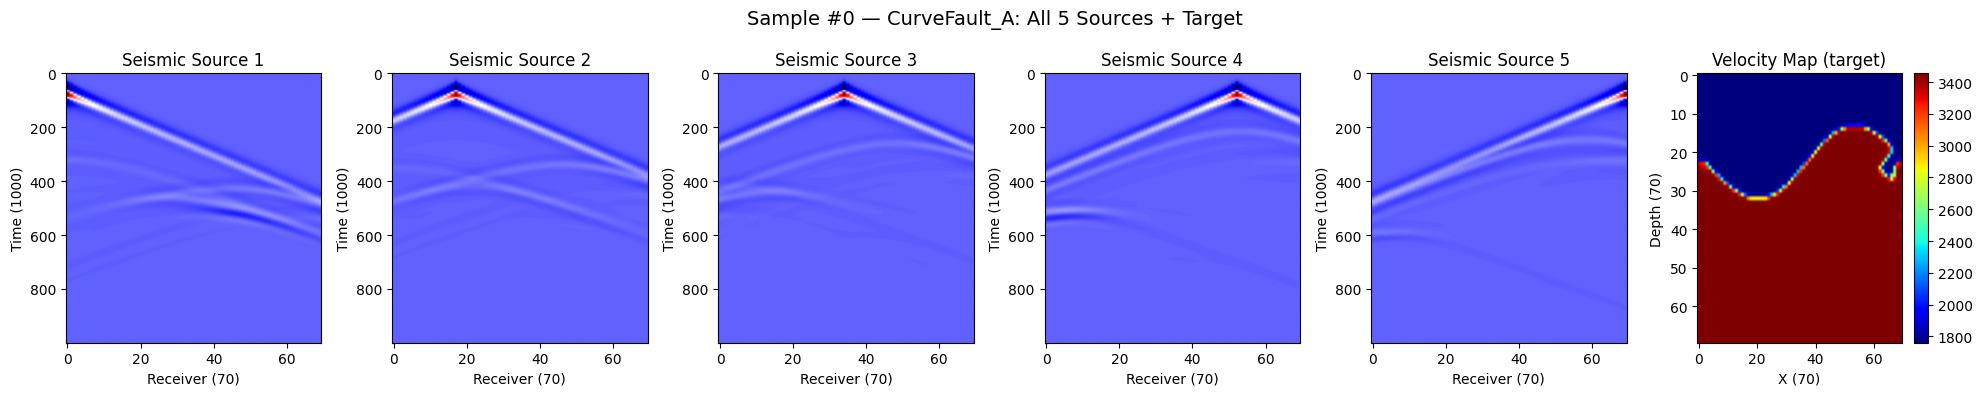

In [45]:
sample_idx = 0

fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for i in range(5):
    axes[i].imshow(seis[sample_idx, i], cmap='seismic', aspect='auto')
    axes[i].set_title(f"Seismic Source {i+1}")
    axes[i].set_xlabel("Receiver (70)")
    axes[i].set_ylabel("Time (1000)")

im = axes[5].imshow(vel[sample_idx, 0], cmap='jet', aspect='auto')
axes[5].set_title("Velocity Map (target)")
axes[5].set_xlabel("X (70)")
axes[5].set_ylabel("Depth (70)")
plt.colorbar(im, ax=axes[5])

plt.suptitle(f"Sample #{sample_idx} — CurveFault_A: All 5 Sources + Target", fontsize=14)
plt.tight_layout()
plt.show()

## Step 5 - Compare All Dataset Types

Different geological scenarios look very different. Let's visualize one sample from 
each dataset type — this shows us the variety our model needs to learn.

Notice how:
- **Fault datasets** have sharp horizontal/diagonal boundaries
- **Velocity datasets** have smooth gradual transitions
- **Style datasets** have more complex irregular patterns

Dataset types found: ['CurveFault_A', 'CurveFault_B', 'CurveVel_A', 'CurveVel_B', 'FlatFault_A', 'FlatFault_B', 'FlatVel_A', 'FlatVel_B', 'Style_A', 'Style_B']


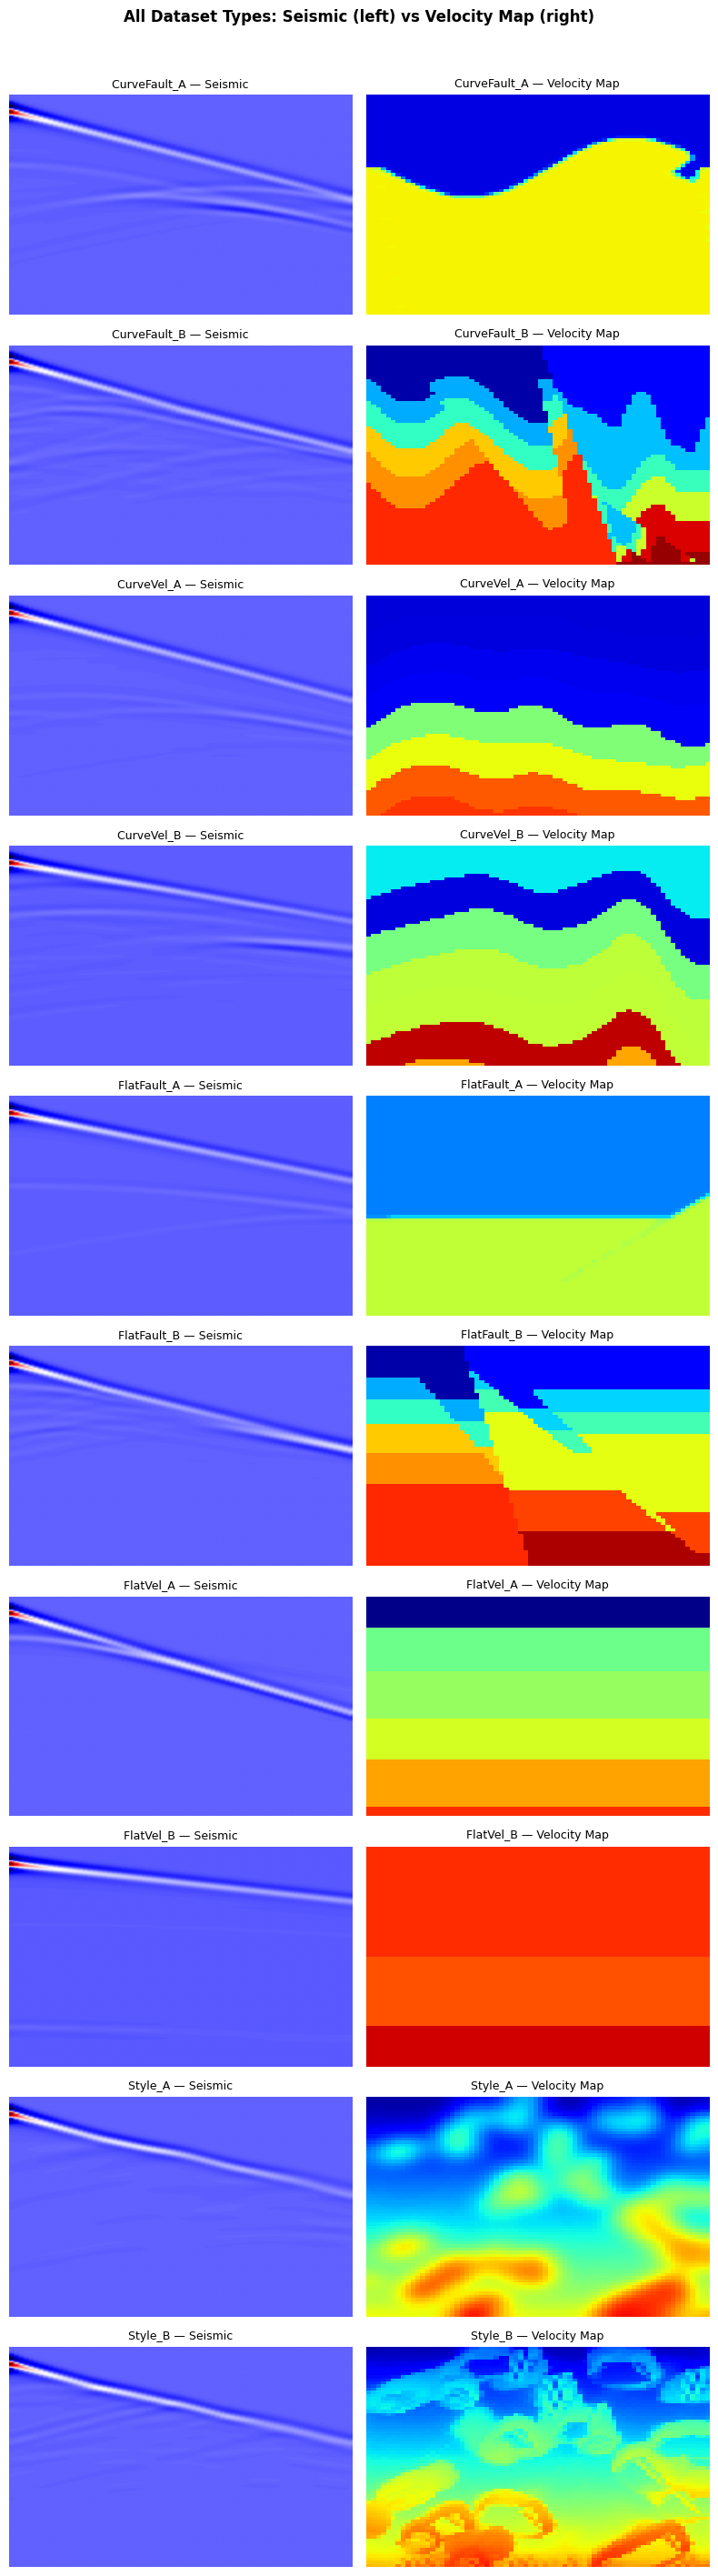

In [46]:
folders = [f for f in sorted(os.listdir(data_root)) 
           if os.path.isdir(os.path.join(data_root, f))]

print("Dataset types found:", folders)

fig, axes = plt.subplots(len(folders), 2, figsize=(8, len(folders) * 2.8))

for i, folder in enumerate(folders):
    folder_path = os.path.join(data_root, folder)
    model_dir = os.path.join(folder_path, "model")
    data_dir  = os.path.join(folder_path, "data")

    if os.path.isdir(model_dir):
        vel_file  = os.path.join(model_dir, sorted(os.listdir(model_dir))[0])
        seis_file = os.path.join(data_dir,  sorted(os.listdir(data_dir))[0])
    else:
        all_files = os.listdir(folder_path)
        vel_file  = os.path.join(folder_path, sorted([f for f in all_files if f.startswith("vel")])[0])
        seis_file = os.path.join(folder_path, sorted([f for f in all_files if f.startswith("seis")])[0])

    v = np.load(vel_file,  allow_pickle=True)[0, 0]
    s = np.load(seis_file, allow_pickle=True)[0, 0]

    axes[i, 0].imshow(s, cmap='seismic', aspect='auto')
    axes[i, 0].set_title(f"{folder} — Seismic", fontsize=9)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(v, cmap='jet', vmin=1500, vmax=4500, aspect='auto')
    axes[i, 1].set_title(f"{folder} — Velocity Map", fontsize=9)
    axes[i, 1].axis('off')

plt.suptitle("All Dataset Types: Seismic (left) vs Velocity Map (right)", 
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("../outputs/all_dataset_types.png", dpi=150, bbox_inches='tight')
plt.show()

## Step 6 - Data Statistics & Velocity Distribution

Understanding the distribution of velocity values helps us decide how to 
normalize the data for training. 

We expect to see values between **1500 m/s** (water/soft sediment) and 
**4500 m/s** (hard rock). The distribution shape tells us if certain 
velocity ranges are more common than others.

Total samples in this file: 500
Input shape per sample:  (5, 1000, 70)  (5 sources, 1000 timesteps, 70 receivers)
Target shape per sample: (1, 70, 70)  (1 channel, 70 depth, 70 width)

Velocity range: 1501 m/s  to  4500 m/s
Seismic range:  -26.0585  to  52.2163


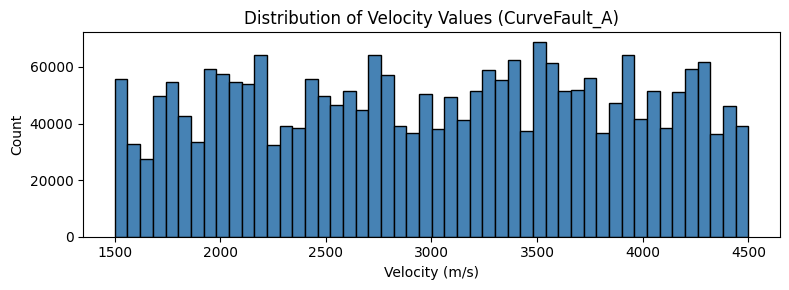

In [47]:
print(f"Total samples in this file: {seis.shape[0]}")
print(f"Input shape per sample:  {seis[0].shape}  (5 sources, 1000 timesteps, 70 receivers)")
print(f"Target shape per sample: {vel[0].shape}  (1 channel, 70 depth, 70 width)")
print(f"\nVelocity range: {vel.min():.0f} m/s  to  {vel.max():.0f} m/s")
print(f"Seismic range:  {seis.min():.4f}  to  {seis.max():.4f}")

plt.figure(figsize=(8, 3))
plt.hist(vel.flatten(), bins=50, color='steelblue', edgecolor='k')
plt.title("Distribution of Velocity Values (CurveFault_A)")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Step 7 - Velocity vs Depth Profile

A **depth profile** shows how velocity changes as we go deeper underground — 
similar to what geologists call a "well log". 

Typically velocity increases with depth as rock becomes denser under pressure. 
Faults appear as sudden jumps in the profile.

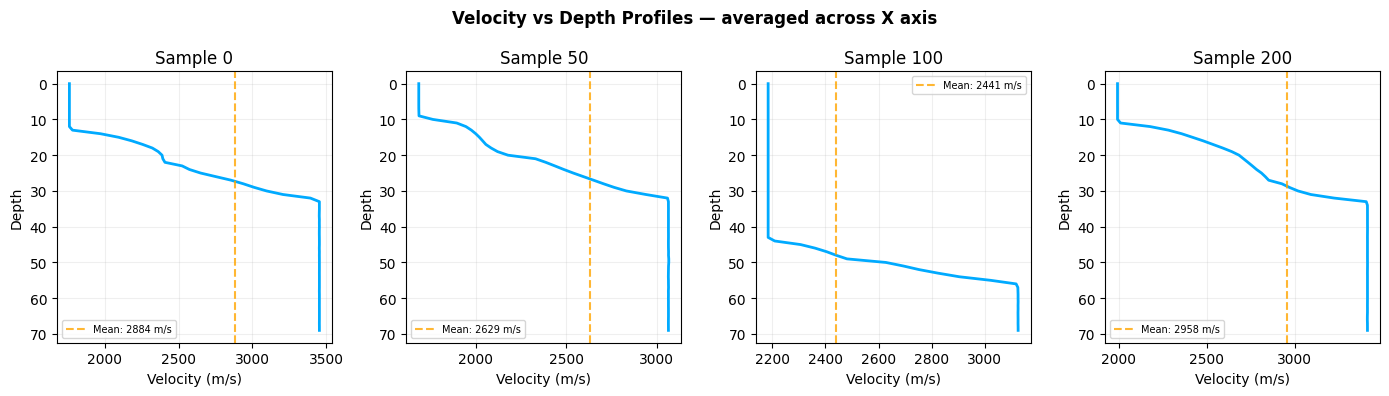

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
sample_indices = [0, 50, 100, 200]

for ax, idx in zip(axes, sample_indices):
    vel_map       = vel[idx, 0]
    depth_profile = vel_map.mean(axis=1)

    ax.plot(depth_profile, range(len(depth_profile)), color='#00aaff', linewidth=2)
    ax.invert_yaxis()
    ax.set_xlabel("Velocity (m/s)")
    ax.set_ylabel("Depth")
    ax.set_title(f"Sample {idx}")
    ax.axvline(x=depth_profile.mean(), color='orange', linestyle='--', 
               alpha=0.8, label=f"Mean: {depth_profile.mean():.0f} m/s")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.2)

plt.suptitle("Velocity vs Depth Profiles — averaged across X axis", 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("../outputs/depth_profiles.png", dpi=150, bbox_inches='tight')
plt.show()

## Step 8 - Building the PyTorch Dataset & DataLoader

Now we set up a proper data pipeline. Key preprocessing steps:

- **Seismic normalization:** Zero mean, unit std per sample - removes amplitude differences
- **Velocity normalization:** Scale from [1500, 4500] m/s -> [0, 1] for stable training
- **Train/Val split:** 90% training (9,000 samples), 10% validation (1,000 samples)

In [48]:
sys.path.append("../src")
from dataset import SeismicDataset, get_dataloaders

data_root = "../data/train_samples"
train_loader, val_loader = get_dataloaders(data_root, batch_size=4, num_workers=0)

seis_batch, vel_batch = next(iter(train_loader))
print(f"Seismic batch shape: {seis_batch.shape}")
print(f"Velocity batch shape: {vel_batch.shape}")
print(f"Seismic range after norm: {seis_batch.min():.3f} to {seis_batch.max():.3f}")
print(f"Velocity range after norm: {vel_batch.min():.3f} to {vel_batch.max():.3f}")

✅ Dataset ready: 10000 total samples
Train samples: 9000 | Val samples: 1000
Train batches: 2250 | Val batches: 250
Seismic batch shape: torch.Size([4, 5, 1000, 70])
Velocity batch shape: torch.Size([4, 1, 70, 70])
Seismic range after norm: -15.173 to 29.321
Velocity range after norm: 0.041 to 0.936


## Step 9 - Building the UNet Model

We use a **UNet architecture** with a custom seismic encoder.

### The Challenge
Input `(5, 1000, 70)` and output `(1, 70, 70)` have very different shapes — 
the model must compress 1000 time steps into a 70×70 spatial grid.

### How it works:
1. **SeismicEncoder** — collapses time dimension: `(5, 1000, 70)` → `(64, 70, 70)`
2. **UNet Encoder** — downsamples: `70 → 35 → 17 → 8`, learning complex patterns
3. **Bottleneck** — most compressed representation of the input
4. **UNet Decoder** — upsamples back to 70×70 using skip connections from encoder
5. **Output** — velocity map in [0, 1], denormalized back to m/s

**12.5M trainable parameters**

In [49]:
import importlib
import torch

for mod in ['model']:
    if mod in sys.modules:
        del sys.modules[mod]

import model as model_module
importlib.reload(model_module)
from model import WaveformUNet, count_parameters

model = WaveformUNet(base_ch=64)
count_parameters(model)

dummy_input = torch.randn(4, 5, 1000, 70)
output = model(dummy_input)

print(f"\nInput shape:  {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output range: {output.min():.3f} to {output.max():.3f}")

Total parameters:     12,510,881
Trainable parameters: 12,510,881

Input shape:  torch.Size([4, 5, 1000, 70])
Output shape: torch.Size([4, 1, 70, 70])
Output range: 0.201 to 0.771


## Step 10 - Training the Model

We train using:
- **Loss:** MAE (L1) + MSE (L2) combined — robust yet sensitive to large errors
- **Optimizer:** Adam with weight decay for regularization  
- **Scheduler:** Reduces learning rate when validation loss stops improving
- **Checkpointing:** Best model saved automatically based on validation loss

> ⚠️ Only 2 epochs here to verify the pipeline. For competitive results, 
> train 50–100 epochs on Kaggle's free GPU.

Using device: mps
✅ Dataset ready: 10000 total samples
Train samples: 9000 | Val samples: 1000
Train batches: 1125 | Val batches: 125
Total parameters:     12,510,881
Trainable parameters: 12,510,881

🚀 Starting training for 2 epochs...

── Epoch 1/2 ──────────────────────────
  Batch 100/1125 | Loss: 0.1895 | MAE: 494.3 m/s
  Batch 200/1125 | Loss: 0.1088 | MAE: 301.0 m/s
  Batch 300/1125 | Loss: 0.1373 | MAE: 371.3 m/s
  Batch 400/1125 | Loss: 0.1117 | MAE: 308.4 m/s
  Batch 500/1125 | Loss: 0.1389 | MAE: 373.9 m/s
  Batch 600/1125 | Loss: 0.1144 | MAE: 313.4 m/s
  Batch 700/1125 | Loss: 0.1220 | MAE: 333.9 m/s
  Batch 800/1125 | Loss: 0.1446 | MAE: 386.5 m/s
  Batch 900/1125 | Loss: 0.1480 | MAE: 395.9 m/s
  Batch 1000/1125 | Loss: 0.0957 | MAE: 266.5 m/s
  Batch 1100/1125 | Loss: 0.1698 | MAE: 454.3 m/s
  Train Loss: 0.1480 | Train MAE: 396.7 m/s
  Val   Loss: 0.1616 | Val   MAE: 431.0 m/s
  ✅ Best model saved (val_loss=0.1616)
── Epoch 2/2 ──────────────────────────
  Batch 100/11

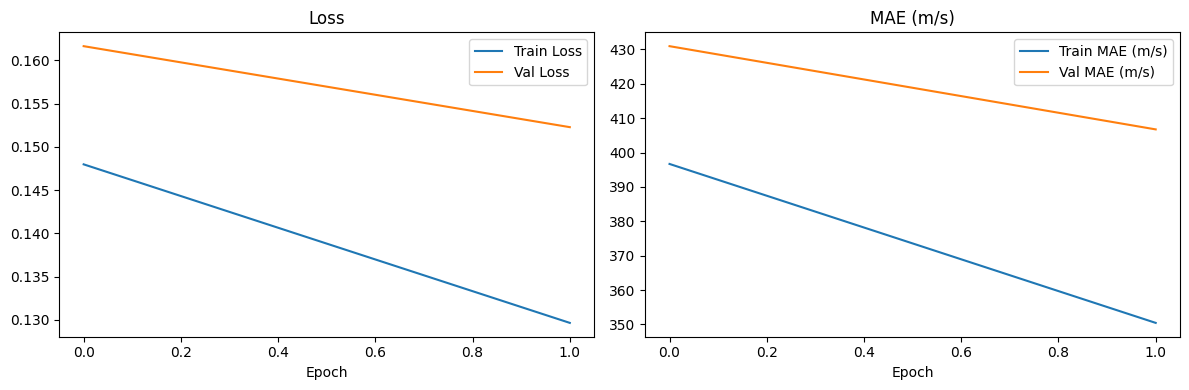

Curves saved to ../outputs/checkpoints/training_curves.png

🎉 Training complete!


In [50]:
for mod in ['train', 'model', 'dataset']:
    if mod in sys.modules:
        del sys.modules[mod]

import train as train_module
importlib.reload(train_module)
from train import train

model, history = train(
    data_root      = "../data/train_samples",
    checkpoint_dir = "../outputs/checkpoints",
    epochs         = 2,
    batch_size     = 8,
    lr             = 1e-3,
)

## Step 11 - Evaluating Predictions

Let's load our best saved model and visually compare predictions vs ground truth.

**3 rows:**
- **Row 1 — Ground Truth:** Actual velocity map from dataset
- **Row 2 — Predicted:** What our model thinks the underground looks like  
- **Row 3 — Absolute Error:** Where the model is wrong (brighter = larger error)

With only 2 epochs, the model captures rough structure. More training sharpens boundaries.

In [51]:
for mod in ['model', 'dataset', 'train']:
    if mod in sys.modules:
        del sys.modules[mod]

from model import WaveformUNet
from dataset import SeismicDataset

dataset   = SeismicDataset("../data/train_samples", normalize=True)
device    = torch.device("cpu")
model     = WaveformUNet(base_ch=64).to(device)
checkpoint = torch.load("../outputs/checkpoints/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']}")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val MAE:  {checkpoint['val_mae']:.1f} m/s")

✅ Dataset ready: 10000 total samples
✅ Loaded model from epoch 2
   Val Loss: 0.1523
   Val MAE:  406.7 m/s


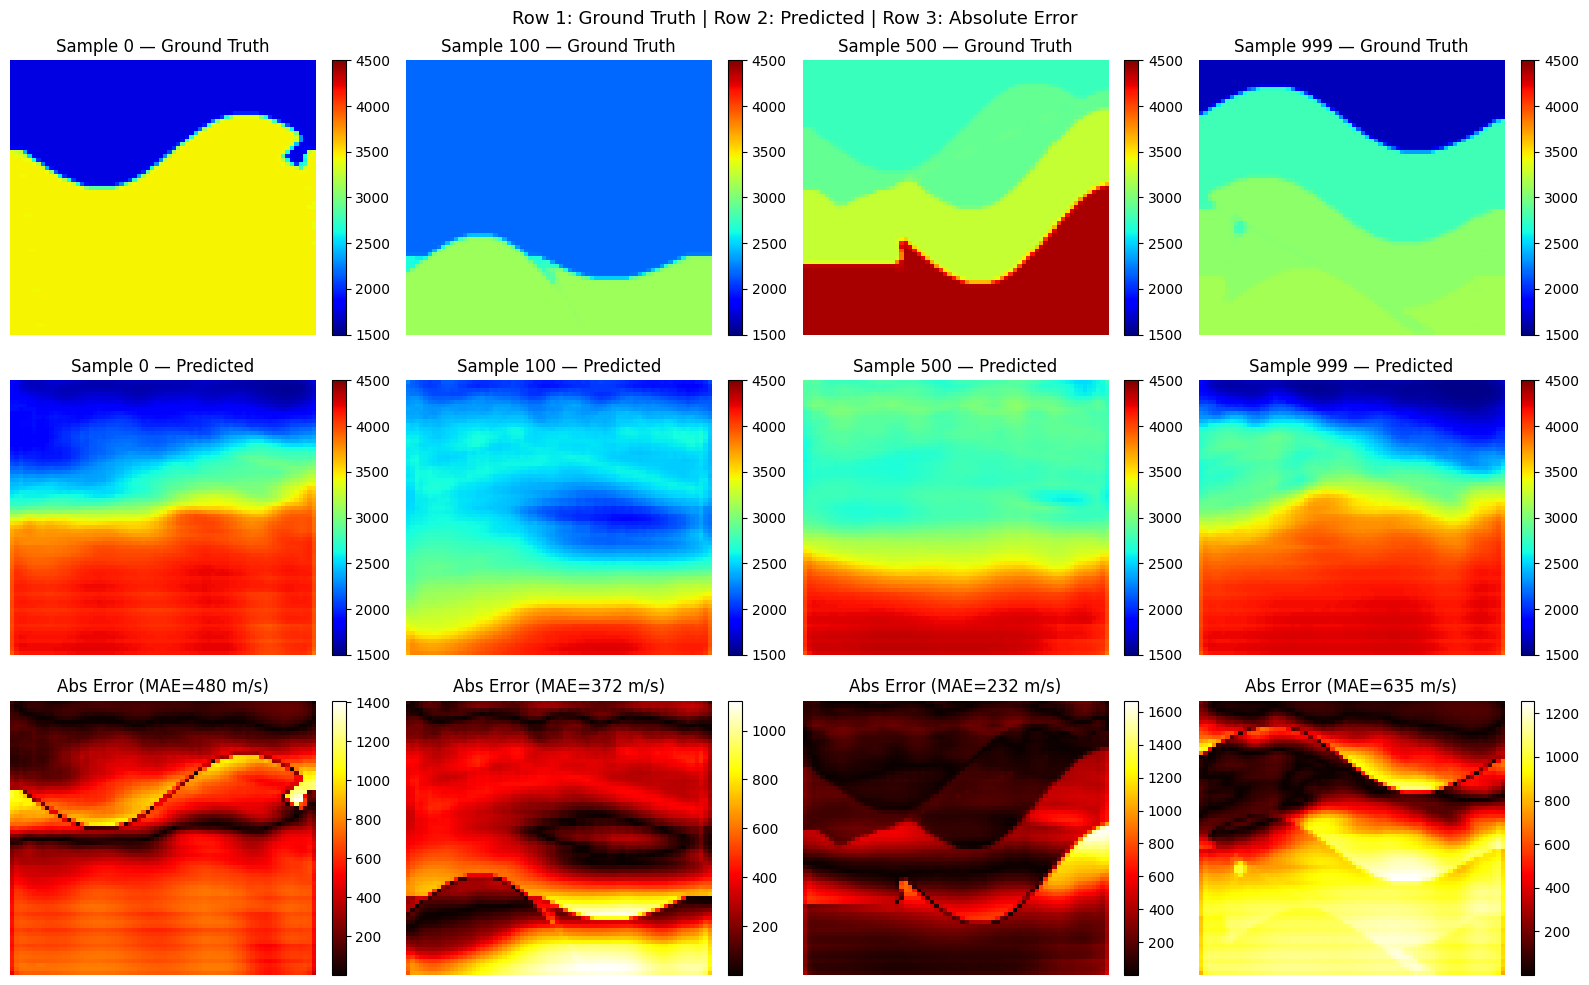

In [52]:
import numpy as np

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
indices = [0, 100, 500, 999]

for col, idx in enumerate(indices):
    seis_s, vel_true = dataset[idx]
    with torch.no_grad():
        vel_pred = model(seis_s.unsqueeze(0)).squeeze().numpy()

    vel_true_np = vel_true.squeeze().numpy()
    vel_true_ms = vel_true_np * 3000.0 + 1500.0
    vel_pred_ms = vel_pred    * 3000.0 + 1500.0
    error_map   = np.abs(vel_pred_ms - vel_true_ms)

    im0 = axes[0, col].imshow(vel_true_ms, cmap='jet', vmin=1500, vmax=4500, aspect='auto')
    axes[0, col].set_title(f"Sample {idx} — Ground Truth")
    axes[0, col].axis('off')
    plt.colorbar(im0, ax=axes[0, col], fraction=0.046)

    im1 = axes[1, col].imshow(vel_pred_ms, cmap='jet', vmin=1500, vmax=4500, aspect='auto')
    axes[1, col].set_title(f"Sample {idx} — Predicted")
    axes[1, col].axis('off')
    plt.colorbar(im1, ax=axes[1, col], fraction=0.046)

    im2 = axes[2, col].imshow(error_map, cmap='hot', aspect='auto')
    axes[2, col].set_title(f"Abs Error (MAE={error_map.mean():.0f} m/s)")
    axes[2, col].axis('off')
    plt.colorbar(im2, ax=axes[2, col], fraction=0.046)

plt.suptitle("Row 1: Ground Truth | Row 2: Predicted | Row 3: Absolute Error", fontsize=13)
plt.tight_layout()
plt.savefig("../outputs/predictions_visualization.png", dpi=150, bbox_inches='tight')
plt.show()